# Trial implementation of REINFORCE from scratch
- Env : CartPole-v0

### Imports

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set initial seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque

## Define the environment

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
print('Observation space:',env.observation_space)
print('Action space:',env.action_space)

Observation space: Box(4,)
Action space: Discrete(2)


## Lets try first with a random policy

In [3]:
class Policy():
    def act(self,state):
        return np.random.choice(2),None

### Implement a basic episode

In [6]:
policy = Policy()
def reinforce(n_episodes = 1000, max_t = 1000, epsilon = 1.0, deque_len = 100):
    
    scores = []
    scores_deque = deque(maxlen=deque_len) # This is there to track the scores achieved in the last deque_len episodes only
    
    for i_episode in range(1,n_episodes+1):
        state = env.reset()
        rewards = []
        for t in range(max_t):
            action, action_probs = policy.act(state)
            next_state,reward,done,info = env.step(action)
            rewards.append(reward)
            if done==True:
                break
        scores.append(sum(rewards))
        scores_deque.append(sum(rewards))
        
        if i_episode%100==0:
            print('Episodes: {}\t Sum of rewards in the past {} episodes = {}'.format(i_episode, deque_len, np.mean(scores_deque)))
            
    return scores

In [7]:
scores = reinforce()

Episodes: 100	 Sum of rewards in the past 100 episodes = 22.63
Episodes: 200	 Sum of rewards in the past 100 episodes = 23.84
Episodes: 300	 Sum of rewards in the past 100 episodes = 21.55
Episodes: 400	 Sum of rewards in the past 100 episodes = 22.15
Episodes: 500	 Sum of rewards in the past 100 episodes = 23.3
Episodes: 600	 Sum of rewards in the past 100 episodes = 20.64
Episodes: 700	 Sum of rewards in the past 100 episodes = 21.31
Episodes: 800	 Sum of rewards in the past 100 episodes = 21.1
Episodes: 900	 Sum of rewards in the past 100 episodes = 21.38
Episodes: 1000	 Sum of rewards in the past 100 episodes = 23.53


# Policy approximation using NN

In [20]:
class Policy(nn.Module):
    """
    This class implements a Neural Network as a function approximator for a policy.
    """
    
    def __init__(self, s_size=4, h_size=16, a_size=2):
        
        # We need to initialize the nn.Module class within Policy(). 
        super(Policy, self).__init__() # The super initializes the nn.Module parentclass 
        self.fc1 = nn.Linear(s_size, h_size) # First layer
        self.fc2 = nn.Linear(h_size, a_size) # Second layer
        
    def forward(self, input_state):
        h_state = F.relu(self.fc1(input_state))
        out_state = self.fc2(h_state)
        out = F.softmax(out_state, dim=1) 
        return out
    
    def act(self, state):
        state_in_torch = torch.from_numpy(state).float().unsqueeze(0).to(device) # Convert the state (as a numpy array) into a torch tensor       
        action_probs = self.forward(state_in_torch).cpu() # Pass the input state from the network and get action probs
        m = Categorical(action_probs) # Creates an object with categorical distributions based on the action_probs
        action = m.sample() # Select the actions weighed by their action_probs

        # We need to return what action to take and its log probability
        # action.item() returns the action to take
        # m.log_prob(action) returns the log probability of taking that action 
        
        return action.item(), m.log_prob(action) 

### Lets try without training the policy how this works
Should work exactly similar to a random policy.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [9]:
scores = reinforce()

Episodes: 100	 Sum of rewards in the past 100 episodes = 21.19
Episodes: 200	 Sum of rewards in the past 100 episodes = 20.83
Episodes: 300	 Sum of rewards in the past 100 episodes = 22.01
Episodes: 400	 Sum of rewards in the past 100 episodes = 22.0
Episodes: 500	 Sum of rewards in the past 100 episodes = 21.31
Episodes: 600	 Sum of rewards in the past 100 episodes = 20.74
Episodes: 700	 Sum of rewards in the past 100 episodes = 21.07
Episodes: 800	 Sum of rewards in the past 100 episodes = 20.42
Episodes: 900	 Sum of rewards in the past 100 episodes = 21.66
Episodes: 1000	 Sum of rewards in the past 100 episodes = 22.39


## Implement with training the policy
As seen above, an untrained network behaves exactly like a random policy.
Now lets write the code for training the policy

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [25]:
def reinforce(n_episodes = 1000, max_t = 1000, epsilon = 1.0, deque_len = 100, gamma = 1.0, print_every=100):
    
    scores = [] # List of cumulative reward received per episode
    scores_deque = deque(maxlen=deque_len) # This is there to track the scores achieved in the last deque_len episodes only
    
    for i_episode in range(1,n_episodes+1):
        
        state = env.reset() 
        rewards = [] # Rewards received for an episode
        saved_log_probs = [] # Log probs for an episode
        
        for t in range(max_t):
            action, action_probs = policy.act(state)
            saved_log_probs.append(action_probs)
            
            state,reward,done,info = env.step(action)
            rewards.append(reward)
            
            if done==True:
                break
        
        scores.append(sum(rewards))
        scores_deque.append(sum(rewards))
        
        # After the episode, calculate the loss
        
        discounts = [gamma**i for i in range(len(rewards)+1)] # Rewards with discounting
        R = sum([a*b for a,b in zip(discounts, rewards)])
        

        policy_loss = []
        for log_prob in saved_log_probs:
            # Based on the log probability of the action and received reward, calculate the cumulative policy loss
            policy_loss.append(-log_prob * R) 
        
        policy_loss = torch.cat(policy_loss).sum() # Concatenate all the policy loss values
        
        optimizer.zero_grad() #TODO: Why zero_grad()
        policy_loss.backward()  #TODO: Why backward()
        optimizer.step() #TODO: Why step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break

    return scores

In [26]:
scores = reinforce()

Episode 100	Average Score: 31.83
Episode 200	Average Score: 57.33
Episode 300	Average Score: 83.57
Episode 400	Average Score: 75.08
Episode 500	Average Score: 178.05
Environment solved in 444 episodes!	Average Score: 195.17


## Plot the scores

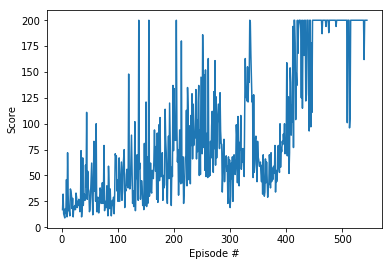

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [28]:
env = gym.make('CartPole-v0')
rewards=[]
state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        break 

        
env.close()